# Step 1: Download various data files by cloning the paper's Git repo.

---
*Note to reviewers: PLEASE DO NOT STAR OR FORK THE REPO WHICH IS DEANONYMIZING. The Github repository helps clone important files necessary for analysis.*

This git repository has various data files Which we clone below to allow you to run the google colab. There is no need to go to the original git repository the process of running this code leads to the files being downloaded and attached to this notebook.

In [1]:
!git clone https://github.com/EricKenjiLee/WaveMAP_Paper.git

fatal: destination path 'WaveMAP_Paper' already exists and is not an empty directory.


## Step 1a: Importing packages

Here are imported standard packages.

In [2]:
# Importing packages
# --- Importing matplotlib, seaborn, etc.
#!pip install umap-learn
#!pip install python-louvain
#!pip install networkx

import os
import random

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy import io
import pickle as pkl
import h5py
import xml.etree.ElementTree as ET
import community.community_louvain as cl
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

These non-standard packages are pinned for compatibility reasons. Google Colab's default versions for import change frequenetly.

In [3]:
# !pip install networkx==2.4
# import networkx as nx

# !pip install scikit-learn==0.22.2.post1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

# !pip install xgboost
# import xgboost as xgb

#!pip install umap-learn==0.5.0
import umap.umap_ as umap

# !pip install cylouvain==0.2.2
#import cylouvain

!pip install shap==0.35
import shap

#!pip install igraph==0.8.2
#import igraph as ig

!pip install pandas<2.0.0

Defaulting to user installation because normal site-packages is not writeable
/bin/bash: 2.0.0: No such file or directory


## Colormap selection for clusterings


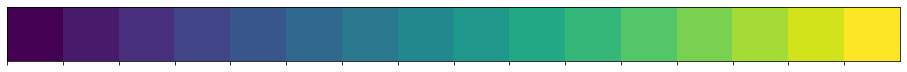

In [4]:
cluster_colors = [
    '#440154',
    '#481a6c',
    '#472f7d',
    '#414487',
    '#39568c',
    '#31688e',
    '#2a788e',
    '#23888e',
    '#1f988b',
    '#22a884',
    '#35b779',
    '#54c568',
    '#7ad151',
    '#a5db36',
    '#d2e21b',
    '#fde725'
]

sns.palplot(cluster_colors)


# Setting of parameters

---

This sets various global parameters like sampling rate, U-probe depths, and random seed state. Setting the random seed at the level of the Python kernel, Numpy, and random packages is essential to produce the same qualitative WaveMAP projection across instances. Note that qualitatively, the results be the same no matter the seed because it affects the projection step of the algorithm and note the graph construction (the latter is what is used in clustering).

In [5]:
#These are the depths that the V-probe channels are located at
DEPTHS = [0.15,0.3,0.45,0.60,0.75,0.9,1.05,1.20,1.35,1.50,1.65,1.80,1.95,2.1,2.25,2.4]

#This converts time points to real time. There are 48 samples per waveform colleted at 30 kilosamples
SAMP_RATE_TO_TIME = 1/(48/30000)

#Setting of random seed across Python kernel and packages to ensure reproducibility
RAND_STATE=42
np.random.seed(RAND_STATE)
os.environ['PYTHONHASHSEED'] = str(RAND_STATE)
random.seed(RAND_STATE)

#UMAP Parameters
#The number of neighbors considered when constructing the high-d graph.
#Made more global-information preserving by increasing it from 15 to 20.
N_NEIGHBORS = 20

#The minimum distance between points in the projected space.
#Used for visualization but doesn't affect clustering.
MIN_DIST = 0.1

#Louvain Clustering Parameters
RESOLUTION = 1.5

# BLUE COLOR
BlueCol = '\033[94m'

# Loading of processed waveform data

---

This cell loads varous files including the 250 Hz high-pass 4th order Butterworth-filtered waveforms, the GMM features, BIC values used for selecting number of GMM clusters, and other waveform info.

In [6]:
print(BlueCol + 'Loading data')

rel_path = os.getcwd()
fullDataPath = os.path.join(rel_path,'WaveMAP_Paper/data/full_data.npy');
GMMclasslabelpath = os.path.join(rel_path,
'WaveMAP_Paper/data/waveformsClassified_250hz_refiltered.mat')
GMMfeaturepath = os.path.join(rel_path,
'WaveMAP_Paper/data/gmm_features.mat')
BICpath = os.path.join(rel_path,
'WaveMAP_Paper/data/BIC_list.mat')
eightclassGMMpath = os.path.join(rel_path,'WaveMAP_Paper/data/8_class_GMM.mat');
filtfulldfPath = os.path.join(rel_path,'WaveMAP_Paper/data/filt_full_df.pkl');

print(rel_path)
print(fullDataPath);
print(GMMclasslabelpath)
print(GMMfeaturepath)
print(BICpath)
print(eightclassGMMpath)
print(filtfulldfPath)

full_data = np.load(fullDataPath)
allDataDFPath = os.path.join(rel_path,'WaveMAP_Paper/data/full_data_df.pkl');

GMM_class_labels = scipy.io.loadmat(GMMclasslabelpath)['classifies'].T
gmm_features_data = scipy.io.loadmat(GMMfeaturepath)['features']

GMM_class_labels = GMM_class_labels[~np.isnan(GMM_class_labels)]
GMM_class_df = pd.DataFrame(GMM_class_labels,columns=['Class'])
gmm_feat_data_nonan = gmm_features_data[~np.isnan(gmm_features_data)].reshape(len(GMM_class_df),3)

BIC_list = scipy.io.loadmat(BICpath)['BIC_list'][0]

eight_GMM_classes = scipy.io.loadmat(eightclassGMMpath)['classifies']

all_data_df = pkl.load(open(allDataDFPath,'rb'))
#filt_full_df = pkl.load(open(filtfulldfPath,"rb"))

print(allDataDFPath)

Loading data
/home/rifische
/home/rifische/WaveMAP_Paper/data/full_data.npy
/home/rifische/WaveMAP_Paper/data/waveformsClassified_250hz_refiltered.mat
/home/rifische/WaveMAP_Paper/data/gmm_features.mat
/home/rifische/WaveMAP_Paper/data/BIC_list.mat
/home/rifische/WaveMAP_Paper/data/8_class_GMM.mat
/home/rifische/WaveMAP_Paper/data/filt_full_df.pkl
/home/rifische/WaveMAP_Paper/data/full_data_df.pkl


# WaveMAP on of waveforms using UMAP and Louvain Clustering.

## Computation of WaveMAP clusters

### First we construct the high-dimensional graph with UMAP

---

Here we run UMAP according to the parameters in the WaveMAP paper. Note that this yields a similar, but not identical UMAP projection to our implementaion. We will proceed with the analysis.

In [7]:
reducer = umap.UMAP(n_neighbors = N_NEIGHBORS, min_dist=MIN_DIST,
                    random_state=RAND_STATE)
mapper = reducer.fit(full_data)
embedding = reducer.transform(full_data)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(full_data)

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


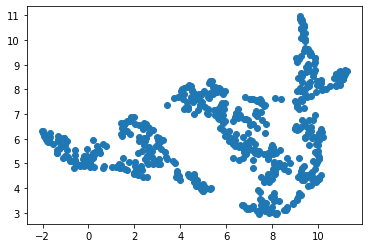

In [8]:
plt.scatter(umap_df.x,umap_df.y)

In [9]:
np.mean(np.std(full_data,axis=1))

0.3490391240013654

### Next we apply Louvain clustering to the high-dimensional UMAP graph

---

This is the graph clustering that operates on the high-dimensional graph found by UMAP and occurs before the projection is computed. Note that in WaveMAP's implementation from Lee et. al, the number of clusters was 8. However, in our implementation the clustering solution changed each time and yielded 12-15 clusters. This is likely due to them optimizing the louvain clustering algorithm in their protocol. However, we were unable to do this and thus proceeded with our method. Note that in the discussion of our final notebook, we compare our results to those in Lee et al. 2021, rather than the ones we obtain here as each time the code is run the clusters are slightly different.

In [25]:
G = nx.from_scipy_sparse_matrix(mapper.graph_)
clustering = cl.best_partition(G, resolution = RESOLUTION)
clustering_solution = list(clustering.values())
umap_df['color'] = clustering_solution

# Debug: Print clustering metrics and solution
#print("Clustering solution:", clustering)

N_CLUST = len(set(clustering_solution))

unique_clusters = set(clustering_solution)
print("Unique clusters:", unique_clusters)
num_clusters = len(unique_clusters)
print("Number of unique clusters:", num_clusters)

Unique clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Number of unique clusters: 15


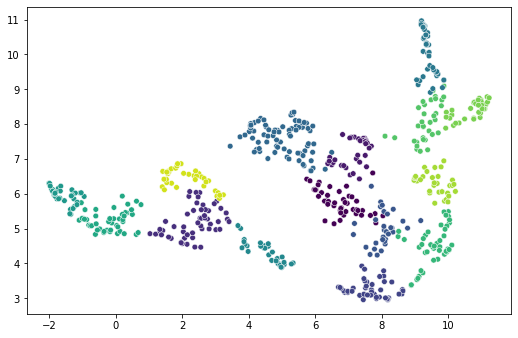

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

# If the number of unique clusters exceeds the available colors, cycle through the colors
if num_clusters > len(cluster_colors):
    cluster_colors = [color for color, _ in zip(cycle(cluster_colors), range(num_clusters))]

# Map cluster numbers to colors
color_map = {cluster: color for cluster, color in zip(unique_clusters, cluster_colors)}
umap_df['color'] = umap_df['color'].map(color_map)

# Plotting
f, arr = plt.subplots(1, figsize=[7, 4.5], tight_layout={'pad': 0})
arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),
            marker='o', c=umap_df['color'].tolist(), s=32, edgecolor='w',
            linewidth=0.5)
plt.show()


### This yields our UMAP graph colored by Louvain cluster

---

Shown is a plot of the UMAP projected space with clusters colored according to high-dimensional graph clusters found in the previous step by Louvain clustering.

In [27]:
# Defines a nice function that plots all the waveforms in long column.
def plot_group(label_ix, labels, groups_df, colors, mean_only=False, detailed=False):
    group_ixs = [i for i,x in enumerate(labels) if x == label_ix-1]
    group_waveforms = groups_df.iloc[group_ixs]['waveform'].tolist()

    f, arr = plt.subplots()
    f.set_figheight(1.8*0.65)
    f.set_figwidth(3.0*0.65)
    if not mean_only:
        for i,_ in enumerate(group_waveforms):
            plt.plot(group_waveforms[i],c=colors[label_ix-1],alpha=0.3,linewidth=1.5)

    if not mean_only:
        plt.plot(np.mean(group_waveforms,axis=0),c='k',linestyle='-')
    else:
        plt.plot(np.mean(group_waveforms,axis=0),c=colors[label_ix-1],linestyle='-')

    arr.spines['right'].set_visible(False)
    arr.spines['top'].set_visible(False)

    if detailed:

        avg_peak = np.mean([np.argmax(x) for x in group_waveforms[14:]])
        arr.axvline(avg_peak,color='k',zorder=0)

        arr.set_ylim([-1.3,1.3])
        arr.set_yticks([])
        arr.set_xticks([0,7,14,21,28,35,42,48])
        arr.tick_params(axis='both', which='major', labelsize=12)
        arr.set_xticklabels([0,'',0.5,'',1.0,'',1.5,''])
        arr.spines['left'].set_visible(False)
        arr.grid(False)
        arr.set_xlim([0,48])

    if not detailed:
        arr.set(xticks=[],yticks=[])

        if not mean_only:
            x,y = 2.1,0.7
            ellipse = mpl.patches.Ellipse((x,y), width=9.0, height=0.72, facecolor='w',
                                 edgecolor='k',linewidth=1.5)
            label = arr.annotate(str(label_ix), xy=(x-0.25, y-0.15),fontsize=12, color = 'k', ha="center")
            arr.add_patch(ellipse)

            if i != -1:
                x, y = 23,-0.7
                n_waveforms = plt.text(x, y,
                                       'n = '+str(len(group_waveforms))+
                                       ' ('+str(round(len(group_waveforms)/len(groups_df)*100,2))+'%)'
                                       , fontsize=10)

    return f, arr

### Lastly we plot the waveforms for each cluster together along with their average waveform

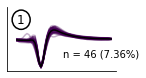

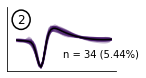

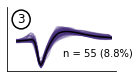

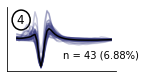

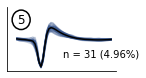

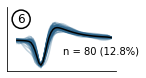

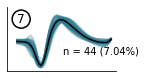

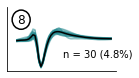

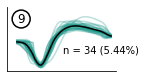

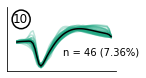

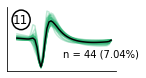

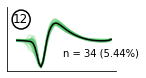

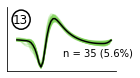

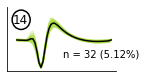

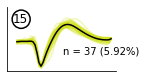

In [28]:
for i in range(1, N_CLUST + 1):
    plot_group(i, clustering_solution, umap_df, cluster_colors)